In [1]:
import os
import torch
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
from torchvision import utils, transforms
import torchio as tio

import nibabel as nib

from sklearn.model_selection import train_test_split

import random
import math

In [2]:
'''
NeuroPyscPhenomics Dataset
'''

class NPPDataset(Dataset):

    '''
    Arguments:
    tsv_path: (string), path to tsv
    root_dir: (string), path to root directory of data
    classes: (list), can include 'CONTROL', 'SCHZ', 'BIPOLAR', 'ADHD'
    is_train: (boolean), true if want training subset
    transform: (methods), transforms that we can define later to augment the
    training samples
    '''
    def __init__(self, tsv_path, root_dir, classes, is_train, h_vs_non = False):
        # Store the parameters as a class variables
        self.tsv_path = os.path.abspath(tsv_path)
        self.root_dir = os.path.abspath(root_dir)
        print(tsv_path, root_dir)
        self.classes = classes
        self.is_train = is_train

        self.mapping = {}

        tsv = pd.read_csv(tsv_path, sep='\t', engine='python')

        # Get participant_id for different classes by accessing the 'diagnosis' column
        # based on which diagnosis are included in classes field
        # 'CONTROL', 'SCHZ', 'BIPOLAR', 'ADHD'
        train_scans = []
        train_labels = []
        val_scans = []
        val_labels = []
        for i,c in enumerate(self.classes):
            self.mapping[i] = c

            d_scans = (tsv[(tsv['dwi'] == 1) & (tsv['diagnosis'] == c)]['participant_id']).to_list()

            # Only use the scans that are in the directory so far
            d_scans = list(set(d_scans).intersection(os.listdir(root_dir)))
            d_labels = [i for l in range(len(d_scans))]

            if len(d_scans) > 0:
                X_train, X_test, y_train, y_test = train_test_split(d_scans, d_labels, test_size=0.2, random_state=3)
                train_scans = train_scans + X_train
                train_labels = train_labels + y_train
                val_scans = val_scans + X_test
                val_labels = val_labels + y_test
                self.scans_by_label[c]=X_train

        # if only training on healthy vs non healthy adjust mapping
        # anything not control becomes 1 and control becomes healthy
        if h_vs_non:
            for i,l in enumerate(train_labels):
                if self.mapping[l] != 'CONTROL':
                    train_labels[i] = 1
                else:
                    train_labels[i] = 0
            self.mapping = {0:'NOT_HEALTHY', 1:'HEALTHY'}

            buffer=[]
            for k,v in self.scans_by_label.items():
                if k != 'CONTROL':
                    buffer = buffer + v
            self.scans_by_label={'HEALTHY': self.scans_by_label['CONTROL'], 'NOT_HEALTHY': buffer, 'NOT_NOT_HEALTHY': self.scans_by_label['CONTROL'] }
        else:
            negatives = {} # build the dictonary of all scans not a label
            for l in self.scans_by_label.keys():
                buffer=[]
                for k,v in self.scans_by_label.items():
                    if k != l:
                        buffer = buffer + v
                negatives['NOT_'+l] = buffer

            for k,v in negatives.items():
                self.scans_by_label[k] = v

        # Set the scan names and labels based on train or validation dataset
        if self.is_train:
            self.scans = train_scans
            self.labels = train_labels
        else:
            self.scans = val_scans
            self.labels = val_labels


        ################################
        # Tensor transformations pt. 2
        ################################

        if self.normalize:
            tfs.append(Normalize(dataset=self, full_normalization=True))

        self.transform = transforms.Compose(tfs)


    '''
    Returns the length of the train dataset
    '''
    def __len__(self):
        return len(self.labels)

    '''
    Given a patient ID in select, and a label open the scan into an array format
    '''
    def openScan(self,select,label):
        # path to the file will be self.root_dir + select + 'anat' + '*.nii.gz'
        file = os.path.join(self.root_dir, select, 'anat', '{}_T1w.nii.gz'.format(select))

        # open thorugh nibabel use nib.load(pathname).get_fdata() to get array
        scan_data = torch.from_numpy(nib.load(file).get_fdata())

        if self.transform:
            scan_data = self.transform(scan_data)

        resized_scans = []
        for i in range(scan_data.shape[0]):
            slice = scan_data[i, :, :]
            resized_slice = transforms.functional.resize(transforms.ToPILImage('L')(slice), (256, 256))
            resized_slice = transforms.functional.to_tensor(resized_slice)
            resized_scans.append(resized_slice)

        resized_scans = torch.stack(resized_scans, 1)

        return resized_scans, label

    '''
    Returns one scan and label corresponding to inx from the dataset.
    '''
    def __getitem__(self, idx):
        label = np.array(self.labels[idx])
        return self.openScan(self.scans[idx],label)

    '''
    Returns a list of scans determiend by the label and scan type. (used for triplet loss)
    A positive scan is any scan of the same label in the training set,
    A negative scan is any scan not of the same label in the training set.
    '''
    def getScan(self, labels, pos):
        scans = []
        for label in labels:
            tag = ('NOT_','')[pos]

            options=self.scans_by_label[tag+label]
            num = random.randrange(len(options)-1)
            selection=options[num]

            resized_scans, label = self.openScan(selection,label)
            scans = scans + resized_scans

        return scans


In [3]:
tsv_path = '../cleanset/participants.tsv'
root_dir = '../cleanset/'
classes = 'CONTROL'

trainset = NPPDataset(tsv_path, root_dir,
                      classes, is_train=True)

../cleanset/participants.tsv ../cleanset/


AttributeError: 'NPPDataset' object has no attribute 'scans_by_label'

In [4]:
tsv = pd.read_csv(tsv_path, sep='\t', engine='python')
tsv

,participant_id,diagnosis,age,gender,bart,bht,dwi,pamenc,pamret,rest,scap,stopsignal,T1w,taskswitch,ScannerSerialNumber,ghost_NoGhost
0,sub-10159,CONTROL,30,F,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
1,sub-10171,CONTROL,24,M,1.0,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
2,sub-10189,CONTROL,49,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
3,sub-10193,CONTROL,40,M,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,35343.0,No_ghost
4,sub-10206,CONTROL,21,M,1.0,NaN,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,35343.0,No_ghost
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,sub-70079,ADHD,21,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost
268,sub-70080,ADHD,48,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost
269,sub-70081,ADHD,50,M,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost
270,sub-70083,ADHD,46,F,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,35426.0,No_ghost


In [5]:
subject_a = tio.Subject(
     t1=tio.ScalarImage('../cleanset/sub-10159/anat/sub-10159_T1w.nii.gz'),
     name='sub-10159',
     diagnosis='CONTROL')

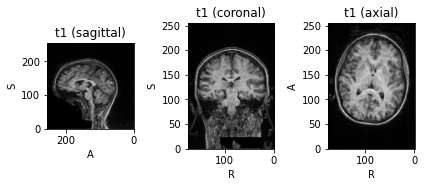

In [6]:
subject_a.plot()

In [13]:
from tqdm import tqdm 

def get_subject_list(tsv_path, root_dir):
    tsv_path = os.path.abspath(tsv_path)
    root_dir = os.path.abspath(root_dir)
    tsv = pd.read_csv(tsv_path, sep='\t', engine='python')
    
    subjects = []
    
    for idx, row in  tqdm(tsv.iterrows(), total=tsv.shape[0]):
        
        participant_id = row['participant_id']
        diagnosis = row['diagnosis']
        age = row['age']
        
        try: 
            subj = tio.Subject(
                t1 = tio.ScalarImage('../cleanset/{}/anat/{}_T1w.nii.gz'.format(participant_id, participant_id)),
                name=participant_id,
                age = age,
                diagnosis=diagnosis
            )
        
            subjects.append(subj)
        except FileNotFoundError:
            print('Could not find file for id: {}! Skipping!'.format(participant_id))
    print('Finished!')
    return subjects

In [14]:
subjects = get_subject_list(tsv_path, root_dir)

100%|██████████| 272/272 [00:00<00:00, 3244.95it/s]

Could not find file for id: sub-10299! Skipping!
Could not find file for id: sub-10428! Skipping!
Could not find file for id: sub-10501! Skipping!
Could not find file for id: sub-10971! Skipping!
Could not find file for id: sub-11121! Skipping!
Could not find file for id: sub-70035! Skipping!
Could not find file for id: sub-70036! Skipping!
Finished!


In [15]:
def create_dataset(labels, subjects, train_transforms, val_transforms, 
                   training_split_ratio=0.8):
    """
    Arguments:
    labels: (list), can include 'CONTROL', 'SCHZ', 'BIPOLAR', 'ADHD'
    subjects: (list), list of all subjects in the dataset 
    train_transforms: transforms for training set 
    val_transforms: transforms for validation set 
    """
    
    filtered_subjects = [subject for subject in subjects if subject.diagnosis in labels]
    num_subjects = len(filtered_subjects)
    
    num_training_subjects = int(training_split_ratio * num_subjects)
    num_validation_subjects = num_subjects - num_training_subjects

    num_split_subjects = num_training_subjects, num_validation_subjects
    training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

    training_set = tio.SubjectsDataset(training_subjects, transform=train_transforms)
    validation_set = tio.SubjectsDataset(validation_subjects, transform=val_transforms)
    
    return training_set, validation_set

In [16]:
classes = ['CONTROL', 'BIPOLAR', 'SCHZ', 'ADHD']
tsv_path = '../cleanset/participants.tsv'
root_dir = '../cleanset/'

train_transforms = tio.Compose([
     tio.RescaleIntensity((0, 1)),
     tio.RandomAffine(),
])

val_transforms = tio.Compose([
     tio.RescaleIntensity((0, 1)),
     tio.RandomAffine(),
])

subjects = get_subject_list(tsv_path, root_dir)

training_set, validation_set = create_dataset(classes, subjects, 
                                              train_transforms, val_transforms)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

100%|██████████| 272/272 [00:00<00:00, 4195.85it/s]

Could not find file for id: sub-10299! Skipping!
Could not find file for id: sub-10428! Skipping!
Could not find file for id: sub-10501! Skipping!
Could not find file for id: sub-10971! Skipping!
Could not find file for id: sub-11121! Skipping!
Could not find file for id: sub-70035! Skipping!
Could not find file for id: sub-70036! Skipping!
Finished!
Training set: 212 subjects
Validation set: 53 subjects


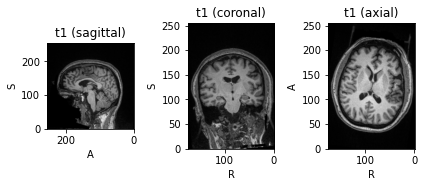

In [17]:
training_set[0].plot()

In [23]:
training_loader = DataLoader(training_set, batch_size=1, num_workers=4)

In [25]:
ex = next(iter(training_loader))

In [29]:
ex['t1'][tio.DATA].shape

torch.Size([1, 1, 176, 256, 256])